In [1]:
import nltk
from nltk.corpus import brown

# (a) getting data

In [2]:
# Download the Brown corpus
nltk.download('brown')

# Load the "news" category and get tagged sentences
tagged_sentences = brown.tagged_sents(categories='news')

# Split into training (90%) and test (10%) sets
split_index = int(0.9 * len(tagged_sentences))
train_set = tagged_sentences[:split_index]
test_set = tagged_sentences[split_index:]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


# MLE

In [3]:
from collections import defaultdict, Counter

def train_baseline(train_set, default_tag='NN', simplify_tags=True):
    """
    Train a baseline model to compute the most likely tag for each word.

    Parameters:
    - train_set: List of tagged sentences (list of (word, tag) tuples).
    - default_tag: Default tag for unknown words (default is 'NN').
    - simplify_tags: Whether to simplify tags by removing parts after '+' or '-' (default is True).

    Returns:
    - word_to_tag: A defaultdict mapping words to their most likely tag. Default value is default_tag.
    """
    # Create a dictionary to count tags for each word
    tag_count = defaultdict(Counter)

    # Count occurrences of each (word, tag) pair in the training set
    for sentence in train_set:
        for word, tag in sentence:
            word = word.lower()  # Convert words to lowercase for consistency
            if simplify_tags:
                # Simplify complex tags by splitting on '+' or '-'
                tag = tag.split('+')[0].split('-')[0]
            tag_count[word][tag] += 1

    # Compute the most likely tag for each word
    word_to_tag = defaultdict(lambda: default_tag)  # Default tag for unknown words
    for word, tags in tag_count.items():
        word_to_tag[word] = max(tags, key=tags.get)  # Select the most frequent tag

    return word_to_tag

# Evaluation

In [4]:
def evaluate_baseline(test_set, most_likely_tags, unknown_tag="NN", simplify_tags=True):
    """
    Evaluate a baseline POS tagger on a test set.

    Parameters:
    - test_set: List of tagged sentences (list of (word, tag) tuples).
    - most_likely_tags: Dictionary or defaultdict mapping words to their most likely tag.
    - unknown_tag: Default tag for unknown words (default is 'NN').
    - simplify_tags: Whether to simplify tags by removing parts after '+' or '-' (default is True).

    Returns:
    - A dictionary with error rates:
        - "Known Error Rate": Error rate for known words.
        - "Unknown Error Rate": Error rate for unknown words.
        - "Total Error Rate": Overall error rate.
    """
    # Initialize counters
    known_error, unknown_error, total_error = 0, 0, 0
    known_count, unknown_count, total_count = 0, 0, 0

    for sentence in test_set:
        for word, true_tag in sentence:
            word = word.lower()  # Normalize word case
            if simplify_tags:
                # Simplify tags to remove modifiers
                true_tag = true_tag.split('+')[0].split('-')[0]

            # Get predicted tag, defaulting to `unknown_tag` for unknown words
            predicted_tag = most_likely_tags.get(word, unknown_tag)

            # Check if word is known or unknown
            if word in most_likely_tags:
                known_count += 1
                if predicted_tag != true_tag:
                    known_error += 1
            else:
                unknown_count += 1
                if predicted_tag != true_tag:
                    unknown_error += 1

            # Update total counters
            total_count += 1
            if predicted_tag != true_tag:
                total_error += 1

    # Safeguard against division by zero
    known_error_rate = known_error / known_count if known_count > 0 else 0
    unknown_error_rate = unknown_error / unknown_count if unknown_count > 0 else 0
    total_error_rate = total_error / total_count if total_count > 0 else 0

    return {
        "Known Error Rate": known_error_rate,
        "Unknown Error Rate": unknown_error_rate,
        "Total Error Rate": total_error_rate,
    }


# b

In [6]:
most_likely_tags = train_baseline(train_set)
baseline_results = evaluate_baseline(test_set, most_likely_tags)
print("\nBaseline Results:")
for key in baseline_results.keys():
    print(key," = ", baseline_results[key])


Baseline Results:
Known Error Rate  =  0.07130937812882412
Unknown Error Rate  =  0.7739463601532567
Total Error Rate  =  0.14442340277085616


# (b) bigram HMM tagger

In [7]:
from collections import defaultdict, Counter
import numpy as np

def train_bigram(train_set, smoothing=False):
    # Transition probabilities
    transitions = defaultdict(Counter)
    emissions = defaultdict(Counter)

    for sentence in train_set:
        prev_tag = "<START>"
        for word, tag in sentence:
            word = word.lower()
            if '+' in tag or '-' in tag:
                tag = tag.split('+')[0].split('-')[0]
            transitions[prev_tag][tag] += 1
            emissions[tag][word] += 1
            prev_tag = tag
        transitions[prev_tag]["<END>"] += 1

    # Normalize probabilities with or without smoothing
    if not smoothing:
        # Without smoothing
        transition_probs = {prev_tag: {tag: count / sum(tags.values()) for tag, count in tags.items()} for
                            prev_tag, tags in transitions.items()}
        emission_probs = {tag: {word: count / sum(words.values()) for word, count in words.items()} for
                          tag, words in emissions.items()}
    else:
        # Vocabulary: all unique words in the training set
        vocab = {word.lower() for sentence in train_set for word, _ in sentence}

        # With Add-One smoothing
        tags = list(emissions.keys())

        # Transition probabilities with smoothing
        transition_probs = {
            prev_tag: {
                tag: (count + 1) / (sum(tags.values()) + len(emissions))
                for tag, count in tags.items()
            }
            for prev_tag, tags in transitions.items()
        }
        # Add unseen tags in the transition probabilities
        for prev_tag in transitions:
            for tag in tags:
                if tag not in transition_probs[prev_tag]:
                    transition_probs[prev_tag][tag] = 1 / (sum(transitions[prev_tag].values()) + len(emissions))
        # Emission probabilities with smoothing
        emission_probs = {
            tag: {
                word: (count + 1) / (sum(words.values()) + len(vocab))
                for word, count in words.items()
            }
            for tag, words in emissions.items()
        }
        # Add unseen words in the emission probabilities
        for tag in emissions:
            for word in vocab:
                if word not in emission_probs[tag]:
                    emission_probs[tag][word] = 1 / (sum(emissions[tag].values()) + len(vocab))

    return transition_probs, emission_probs

In [8]:
def viterbi(test_set, transition_probs, emission_probs, unknown_tag="NN"):
    results = []
    tags = list(emission_probs.keys())

    for sentence in test_set:
        words = [word.lower() for word, _ in sentence]
        n = len(words)

        # Initialize DP table
        dp = np.zeros((n, len(tags)))
        bp = np.zeros((n, len(tags)), dtype=int)

        # Initialization
        for j, tag in enumerate(tags):
            dp[0, j] = transition_probs.get("<START>", {}).get(tag, 0) * emission_probs.get(tag, {}).get(words[0], 1e-6)

        # Recursion
        for i in range(1, n):
            for j, tag in enumerate(tags):
                max_prob, max_idx = max(
                    (dp[i - 1, k] * transition_probs.get(tags[k], {}).get(tag, 0) * emission_probs.get(tag, {}).get(words[i], 1e-6), k)
                    for k in range(len(tags))
                )
                dp[i, j] = max_prob
                bp[i, j] = max_idx

        # Termination
        max_prob, max_idx = max((dp[n - 1, j] * transition_probs.get(tags[j], {}).get("<END>", 0), j) for j in range(len(tags)))
        best_path = [max_idx]

        # Backtrack
        for i in range(n - 1, 0, -1):
            best_path.append(bp[i, best_path[-1]])

        best_path.reverse()
        results.append([(words[i], tags[best_path[i]]) for i in range(n)])

    return results

# (c) bigram HMM tagger

In [9]:
    print("\nHMM Tagger Results:")
    print("Training...")
    transition_probs, emission_probs = train_bigram(train_set)
    print("Evaluating using viterbi..")
    hmm_results = viterbi(test_set, transition_probs, emission_probs)
    print("Calculating results..")
    hmm_error_rate = evaluate_baseline(hmm_results, most_likely_tags)  # Reuse evaluation method
    for key in hmm_error_rate.keys():
        print(key," = ", hmm_error_rate[key])


HMM Tagger Results:
Training...
Evaluating using viterbi..
Calculating results..
Known Error Rate  =  0.06530203582155969
Unknown Error Rate  =  0.6408045977011494
Total Error Rate  =  0.12518688328515898


# (d) Add-one smoothing

In [10]:
    print("\nHMM Tagger Results:")
    print("Training...")
    transition_probs, emission_probs = train_bigram(train_set, smoothing=True)
    print("Evaluating using viterbi..")
    hmm_results = viterbi(test_set, transi  tion_probs, emission_probs)
    print("Calculating results..")
    hmm_error_rate = evaluate_baseline(hmm_results, most_likely_tags)  # Reuse evaluation method
    for key in hmm_error_rate.keys():
        print(key," = ", hmm_error_rate[key])


HMM Tagger Results:
Training...
Evaluating using viterbi..
Calculating results..
Known Error Rate  =  0.1551896762709979
Unknown Error Rate  =  0.5852490421455939
Total Error Rate  =  0.19994019734874913


# (e) Using psuedo-words

In [20]:
# Define pseudo-words for unknown and low-frequency words
def assign_pseudo_word(word):
    if word.isdigit():
        return "<NUMERIC>"
    elif word.isupper():
        return "<ALLCAPS>"
    elif word.istitle():
        return "<INITCAP>"
    elif "-" in word:
        return "<HYPHEN>"
    elif any(char.isdigit() for char in word):
        return "<ALPHANUMERIC>"
    elif len(word) <= 3:
        return "<SHORT>"
    else:
        return "<UNKNOWN>"

# Update the training data with pseudo-words for low-frequency words
def preprocess_train_data(train_set, freq_threshold=1):
    word_counts = Counter(word.lower() for sentence in train_set for word, _ in sentence)
    processed_train_set = []
    for sentence in train_set:
        processed_sentence = []
        for word, tag in sentence:
            word_lower = word.lower()
            if word_counts[word_lower] <= freq_threshold:
                word = assign_pseudo_word(word)
            processed_sentence.append((word, tag))
        processed_train_set.append(processed_sentence)
    return processed_train_set

# Update the test data with pseudo-words for unknown words
def preprocess_test_data(test_set, known_words):
    processed_test_set = []
    for sentence in test_set:
        processed_sentence = []
        for word, tag in sentence:
            word_lower = word.lower()
            if word_lower not in known_words:
                word = assign_pseudo_word(word)
            processed_sentence.append((word, tag))
        processed_test_set.append(processed_sentence)
    return processed_test_set


In [26]:
# Updated Viterbi to handle pseudo-words
def viterbi_with_pseudo(test_set, transition_probs, emission_probs, known_words, unknown_tag="NN"):
    results = []
    tags = list(emission_probs.keys())

    for sentence in test_set:
        words = [word.lower() for word, _ in sentence]
        words = [word if word in known_words else assign_pseudo_word(word) for word in words]
        n = len(words)

        # Initialize DP table
        dp = np.zeros((n, len(tags)))
        bp = np.zeros((n, len(tags)), dtype=int)

        # Initialization
        for j, tag in enumerate(tags):
            dp[0, j] = transition_probs.get("<START>", {}).get(tag, 0) * emission_probs.get(tag, {}).get(words[0], 1e-6)

        # Recursion
        for i in range(1, n):
            for j, tag in enumerate(tags):
                max_prob, max_idx = max(
                    (dp[i - 1, k] * transition_probs.get(tags[k], {}).get(tag, 0) * emission_probs.get(tag, {}).get(words[i], 1e-6), k)
                    for k in range(len(tags))
                )
                dp[i, j] = max_prob
                bp[i, j] = max_idx

        # Termination
        max_prob, max_idx = max((dp[n - 1, j] * transition_probs.get(tags[j], {}).get("<END>", 0), j) for j in range(len(tags)))
        best_path = [max_idx]

        # Backtrack
        for i in range(n - 1, 0, -1):
            best_path.append(bp[i, best_path[-1]])

        best_path.reverse()
        results.append([(words[i], tags[best_path[i]]) for i in range(n)])

    return results

def evaluate_viterbi_results(test_set, predicted_results):
    """
    Evaluate Viterbi results by comparing predicted tags with true tags.

    Parameters:
    - test_set: List of tagged sentences (list of (word, tag) tuples).
    - predicted_results: List of tagged sentences predicted by Viterbi.

    Returns:
    - A dictionary with error rates:
        - "Known Error Rate": Error rate for known words.
        - "Unknown Error Rate": Error rate for unknown words.
        - "Total Error Rate": Overall error rate.
    """
    known_error, unknown_error, total_error = 0, 0, 0
    known_count, unknown_count, total_count = 0, 0, 0

    for true_sentence, predicted_sentence in zip(test_set, predicted_results):
        for (true_word, true_tag), (_, predicted_tag) in zip(true_sentence, predicted_sentence):
            true_word_lower = true_word.lower()
            # Determine if the word is known or unknown
            if true_word_lower in known_words:
                known_count += 1
                if true_tag != predicted_tag:
                    known_error += 1
            else:
                unknown_count += 1
                if true_tag != predicted_tag:
                    unknown_error += 1

            # Update total counters
            total_count += 1
            if true_tag != predicted_tag:
                total_error += 1

    # Safeguard against division by zero
    known_error_rate = known_error / known_count if known_count > 0 else 0
    unknown_error_rate = unknown_error / unknown_count if unknown_count > 0 else 0
    total_error_rate = total_error / total_count if total_count > 0 else 0

    return {
        "Known Error Rate": known_error_rate,
        "Unknown Error Rate": unknown_error_rate,
        "Total Error Rate": total_error_rate,
    }



In [22]:
# Preprocess training data with pseudo-words
processed_train_set = preprocess_train_data(train_set, freq_threshold=1)

# Extract known words from the processed training set
known_words = set(word.lower() for sentence in processed_train_set for word, _ in sentence)

# Preprocess test data with pseudo-words
processed_test_set = preprocess_test_data(test_set, known_words)


In [27]:
# Train the bigram HMM using the processed training data without smoothing
transition_probs, emission_probs = train_bigram(processed_train_set, smoothing=False)

# Run the Viterbi algorithm with pseudo-words on the test set
viterbi_results_mle = viterbi_with_pseudo(processed_test_set, transition_probs, emission_probs, known_words)

In [28]:
# Evaluate the error rates for the results
error_rates_mle = evaluate_viterbi_results(test_set, viterbi_results_mle)
print("Error rates with pseudo-words and maximum likelihood estimation:")
for key, value in error_rates_mle.items():
    print(f"{key}: {value}")


Error rates with pseudo-words and maximum likelihood estimation:
Known Error Rate: 0.07586367880485527
Unknown Error Rate: 0.5160409556313993
Total Error Rate: 0.140137546097877


In [30]:
# Train the bigram HMM using the processed training data with Add-One smoothing
transition_probs_smooth, emission_probs_smooth = train_bigram(processed_train_set, smoothing=True)

# Run the Viterbi algorithm with pseudo-words on the test set
viterbi_results_smooth = viterbi_with_pseudo(processed_test_set, transition_probs_smooth, emission_probs_smooth, known_words)

In [31]:
# Evaluate the error rates for the results
error_rates_smooth = evaluate_viterbi_results(test_set, viterbi_results_smooth)
print("Error rates with pseudo-words and Add-One smoothing:")
for key, value in error_rates_smooth.items():
    print(f"{key}: {value}")

Error rates with pseudo-words and Add-One smoothing:
Known Error Rate: 0.1469421101774043
Unknown Error Rate: 0.5365187713310581
Total Error Rate: 0.20382736968005583


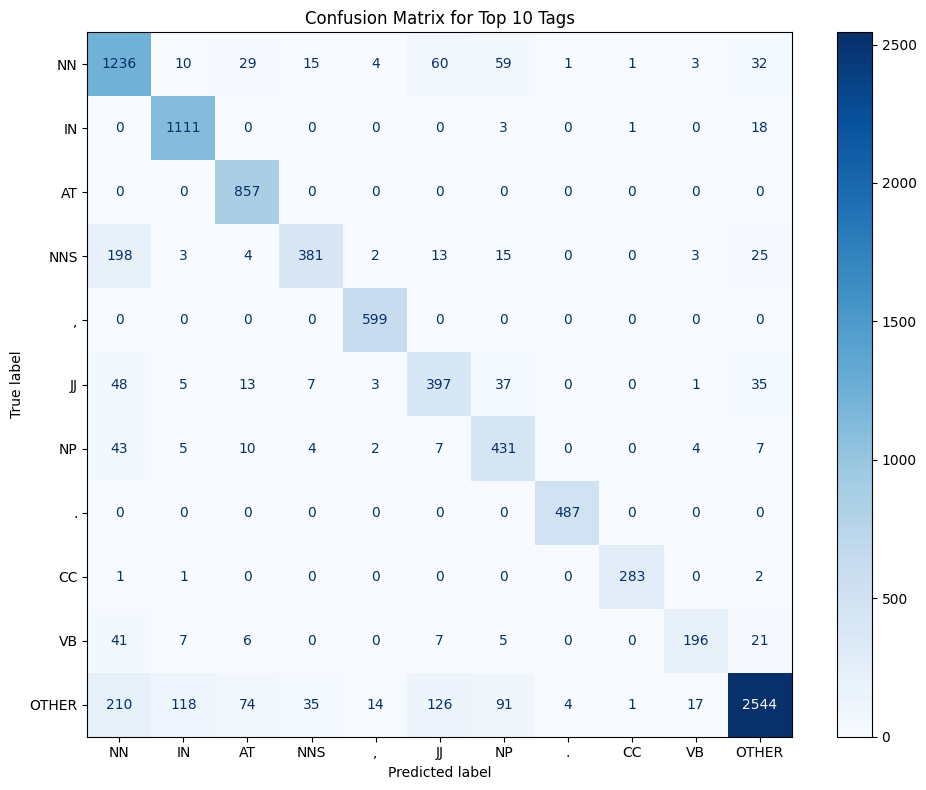

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter

def plot_top_n_confusion_matrix(true_tags, predicted_tags, n=10):
    """
    Plot a confusion matrix for the top N most frequent tags.

    Parameters:
    - true_tags: List of true POS tags.
    - predicted_tags: List of predicted POS tags.
    - n: Number of top tags to display.
    """
    # Count occurrences of each tag
    tag_counts = Counter(true_tags)
    top_tags = [tag for tag, _ in tag_counts.most_common(n)]

    # Filter only the top N tags for both true and predicted tags
    filtered_true_tags = [tag if tag in top_tags else 'OTHER' for tag in true_tags]
    filtered_predicted_tags = [tag if tag in top_tags else 'OTHER' for tag in predicted_tags]

    # Generate the confusion matrix
    cm_labels = top_tags + ['OTHER']
    cm = confusion_matrix(filtered_true_tags, filtered_predicted_tags, labels=cm_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(cmap='Blues', xticks_rotation='horizontal', ax=plt.gca())
    plt.title(f"Confusion Matrix for Top {n} Tags")
    plt.tight_layout()
    plt.show()

# Use the top 10 tags
plot_top_n_confusion_matrix(true_tags, predicted_tags, n=10)